## 14. 순환 신경망(Recurrent Neural Networks, RNN)
<br>

- 14.0 Introduction
- 14.1 순환 뉴런
    - 14.1.1 메모리 셀
    - 14.1.2 입력과 출력 시퀀스
- 14.2 텐서플로로 기본 RNN 구성하기
    - 14.2.1 정적으로 타임 스텝 펼치기
    - 14.2.2 동적으로 타임 스텝 펼치기
    - 14.2.3 가변 길이 입력 시퀀스 다루기
    - 14.2.4 가변 길이 출력 시퀀스 다루기
- 14.3 RNN 훈련하기
    - 14.3.1 분류기 훈련하기
    - 14.3.2 시계열 예측을 위해 훈련하기
    - 14.3.3 RNN의 창조성
- 14.4 심층 RNN
    - 14.4.1 여러 GPU에 심층 RNN 분산하기
    - 14.4.2 드롭아웃 적용하기
    - 14.4.3 많은 타임 스텝에서 훈련의 어려움
- 14.5 LSTM 셀
    - 14.5.1 핍홀 연결
- 14.6 GRU 셀
- 14.7 자연어 처리
    - 14.7.1 워드 임베딩
    - 14.7.2 기계 번역을 위한 인코더-디코더 네트워크
    
## 기본 설정

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'HCR Batang'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

## 14.0 Introduction
<br>

이번에는 미래를 어느정도 예측할 수 있는 네트워크인 순환 신경망을 알아보겠습니다. 이 신경망은 임의 길이의 시퀀스(Sequence)를 다룰 수 있습니다. 예를 들면 문장, 문서, 오디오 샘플을 입력으로 받을 수 있고, 자동 번역, 감정 분석(Sentiment analysis)같은 자연어 처리(NLP)에 유용합니다.
<br><br>

RNN의 핵심 개념을 살펴보고 이것의 주요 문제와 해결하기위한 방법인 LSTM과 GRU셀에 대해 알아보겠습니다. 그리고 텐서플로우로 어떻게 RNN을 구축하는지 알아보고 끝으로 기계 번역 시스템의 구조를 보겟습니다.
<br><br>

## 14.1 순환 뉴런
<br>

지금 까지는 활성화 신호가 입력층에서 출력층으로만 흐르는 피드포워드 신경망을 공부했다면, 순환 신경망은 다릅니다. 거꾸로 향하는 연결이 있습니다.
![순환 뉴런1](.\images\ch14fig1.png)
위 그림은 가장 간단한 RNN구조입니다. 이 순환 뉴런(Recurrent Neuron)은 각 타임 스텝(Time step, 혹은 프래임(Frame)) t 의 입력으로 $x_{(t)}$도 받고 이전 타임 스텝의 출력인 $y_{(t-1)}도 받습니다. 이것을 그림의 오른쪽 처럼 표현을 하면 '시간에 따라 네트워크를 펼쳤다.'라고 말합니다.


순환 뉴런으로 된 층도 쉽게 만들 수 있습니다. 이번에는 입력으로 벡터 $x_{(t)}$와 이전 타임 스텝의 출력 벡터 $y_{(t-1)}$을 받습니다. 즉 입력과 출력 모두 벡터입니다.
![순환 뉴런2](.\images\ch14fig2.png)

각 순환 뉴런은 $x_{(t)}$와 $y_{(t-1)}$를 위한 두 벌의 가중치 벡터를 가집니다. 이것을 $w_x$, $w_y$라고 부르겠습니다. 하나의 뉴런이 아니라 층 전체라고 생각을 한다면 가중치 벡터를 가중치 행렬 $W_x$, $W_y$로 바꿀 수 있습니다. 그럼 하나의 샘플에 대한 순환 층의 식은 다음과 같이 됩니다.
$$ y_{(t)} = \phi({W_x}^T \cdot x_{(t)} + {W_y}^T \cdot y_{(t-1)} + b)$$
- $\phi()$ : 활성화 함수 (대체로 하이퍼볼릭 탄젠트(tanh) 활성화 함수를 선호한다고 합니다.)
- b : 편향

타임 스텝 t에서의 모든 입력을 $X_{(t)}$로 만들어서 미니배치 전체에 대해 순환 층의 출력을 계산할 수 있습니다.
$$ Y_{(t)} = \phi(X_{(t)} \cdot {W_x}^T + Y_{(t)} \cdot {W_y}^T + b) = \phi([X_{(t)} \quad Y_{(t-1)}] \cdot W + b) \quad
여기서 \quad W=
    \begin{bmatrix}
    W_x \\
    W_y \\
    \end{bmatrix}
    $$
- $Y_{(t)}$ : 타임 스텝 t에서 미니 배치에 있는 각 샘플에 대한 층의 출력을 담고 있는 $m \times n_{neurons}$ 행렬 (m: 미니배치의 샘플수, $n_{neurons}$: 뉴런의 수)
- $X_{(t)}$ : 모든 샘플의 입력 값을 담고 있는 $m \times n_{inputs}$ 행렬 ($n_{inputs}$: 입력 특성 수)
- $W_x$ : 현재 타임 스텝의 입력에 대한 연결 가중치를 담고있는 $n_{inputs} \times n_{neurons}$ 행렬
- $W_y$ : 이전 타임 스텝의 출력에 대한 연결 가중치를 담고있는 $n_{inputs} \times n_{neurons}$ 행렬
- $b$ : 각 뉴런의 편향을 담고있는 $n_{neurons}$크기의 벡터
- $W$ : $(n_{inputs} + n_{neurons}) \times n_{neurons}$ 크기의 가중치 행렬

첫 번째 타임 스텝 t=0에서는 이전 출력이 없으므로 일반적으로 모두 0이라고 가정합니다.

## 4.1.1 메모리 셀
<br>

타임 스텝 t에서 순환 뉴런의 출력을 일종의 메모리 형태라고 말 할 수있습니다. 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 메모리 셀(Memory cell, 혹은 셀)이라고 합니다. 하나의 순환 뉴런 혹은 순환 뉴런 층은 기본적인 셀입니다.
<br><br>

일반적으로 타임 스텝 t에서의 셀의 상태 $h_{(t)}$는 그 타임 스텝과 이전 타임 스텝의 상태에 대한 함수 입니다. 즉 $h_{(t)} = f(h_{(t-1)},x_{(t)})$입니다. 타임 스텝에서 $y_{(t)}$도 이전 상태와 현재 입력에 대한 함수입니다. 기본적인 셀인 경우 출력과 셀의 상태는 동일하지만 아래 그림처럼 복잡한 셀에서는 두 값이 다를 수도 있습니다.
![메모리 셀1](.\images\ch14fig3.png)

## 14.1.2 입력과 출력 시퀀스
<br>

입력 시퀀스와 출력 시퀀스를 조절해 다양한 네트워크를 만들 수 있습니다.
![입력과 출력 시퀀스](.\images\ch14fig4.png)
시퀀스-투-시퀀스(왼쪽 위), 시퀀스-투-벡터(오른쪽 위), 벡터-투-시퀀스(왼쪽 아래), 지연된 시퀀스-투-시퀀스(오른쪽 아래)

## 14.2 텐서플로로 기본 RNN 구성하기
<br>

이제 본격적으로 코딩을 시작해보겠습니다. 먼저 내부 구조를 잘 이해하기 위해 텐서플로의 RNN을 쓰지않고 RNN을 구현해보겠습니다.

In [2]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [3]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [4]:
print(Y0_val)
print()
print(Y1_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


## 14.2.1 정적으로 타임 스텝 펼치기
<br>

그럼 이제 텐서플로의 RNN연산을 사용해 같은 모델을 만들어보겠습니다.
<br><br>

static_run()함수는 셀을 연결하여 펼쳐진 RNN 네트워크를 만듭니다.

In [17]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)    # 셀의 복사본을 만드는 펙토리
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0,X1], dtype=tf.float32)   #입력마다 셀의 __call__()함수를 
                                                                                         #호출해 가중치와 편향을 공유

Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [18]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    
print(Y0_val)
print()
print(Y1_val)

[[ 0.30741334 -0.32884315 -0.6542847  -0.9385059   0.52089024]
 [ 0.99122757 -0.9542541  -0.7518079  -0.9995208   0.9820235 ]
 [ 0.9999268  -0.99783254 -0.8247353  -0.9999963   0.99947774]
 [ 0.996771   -0.68750614  0.8419969   0.9303911   0.8120684 ]]

[[ 0.99998885 -0.99976057 -0.0667929  -0.9999803   0.99982214]
 [-0.6524943  -0.51520866 -0.37968948 -0.5922594  -0.08968379]
 [ 0.99862397 -0.99715203 -0.03308626 -0.9991566   0.9932902 ]
 [ 0.99681675 -0.9598194   0.39660627 -0.8307606   0.79671973]]


만약 50개의 타임 스텝이 있으면 50개의 입력 플레이스홀더와 출력 텐서를 만들어야 하는 번거로움이 생깁니다. 이를 간단하게 바꿔어 보겠습니다.

In [19]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1,0,2]))      #n_steps개 텐서를 가진 파이썬 리스트 [None, n_inputs]크기, 첫번째 차원은 미니배치
                                                        #static_run()에서 데이터 처리하기 위해 첫 두차원을 transpose로 바꿈
                                                        #unstack()으로 첫 번째 차원을 따라 텐서의 파이썬 리스트를 추출
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)

outputs = tf.transpose(tf.stack(output_seqs), perm=[1,0,2])

init = tf.global_variables_initializer()

X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # 샘플 1
        [[3, 4, 5], [0, 0, 0]], # 샘플 2
        [[6, 7, 8], [6, 5, 4]], # 샘플 3
        [[9, 0, 1], [3, 2, 1]], # 샘플 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [20]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


하지만 이 방법 또한 타임 스텝마다 하나의 셀을 그래프에 추가합니다. 50개 타임 스텝이 있다면 그래프는 매우 복잡할 것이고 아주 큰 그래프라면 역전파 동안 메모리 부족(Out of memory, OOM)에러가 발생할 수 있습니다.

##  14.2.2 동적으로 타임 스텝 펼치기
<br>

이를 해결할 더 좋은 방법인 dynamic_rnn()함수가 있습니다. 이 함수는 적절한 타임 스텝에 걸쳐 셀을 실행하기 위해 while_loop() 연산을 사용합니다. 그리고 이 함수는 각 타임 스텝의 모든 입력에 대해 텐서 하나를 받고([None, n_steps, n_inputs]크기), 모든 출력도 하나의 텐서([None, n_steps, n_neurons]크기)로 반환 합니다.

In [21]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


##  14.2.3 가변 길이 입력 시퀀스 다루기
<br>

이제까지 고정된 길이(두 개의 타임 스텝)을 가진 입력 시퀀스만 다루었다면 이제는 길이가 변할 수 있는 길이의 입력 시퀀스를 다룰 수 있는 모델을 만들어 보겠습니다. 이 경우엔 dynamic_rnn()(또는 static_rnn())함수를 호출할 때 sequence_length 매개변수를 설정해주면 됩니다. 그리고 샘플의 입력 시퀀스 길이를 1D 텐서로 지정합니다

In [23]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
        # 스텝 0     스텝 1
        [[0, 1, 2], [9, 8, 7]], # 샘플 1
        [[3, 4, 5], [0, 0, 0]], # 샘플 2 (0 벡터로 패딩)
        [[6, 7, 8], [6, 5, 4]], # 샘플 3
        [[9, 0, 1], [3, 2, 1]], # 샘플 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])     #샘플1 에는 2개의 타임 스텝, 샘플2에는 1개의 타임스텝, ....

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})
            
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [25]:
print(states_val)    # 0벡터가 제외된 마지막 상태

[[-1.          0.956726    0.99831694  0.99970174  0.96518576]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]
 [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]


##  14.2.4 가변 길이 출력 시퀀스 다루기
<br>

그럼 출력 시퀀스도 가변 길이로 할 수 있을까요? 각 시퀀스의 길이를 미리 알 수 있다면 앞서 했었던 sequence_length 매개변수에 지정할 수 있겠지만, 일반적으로 이는 불가능하다고 합니다.

##  14.3 RNN 훈련하기
<br>

RNN을 훈련시키는 방법은 앞서 했던 것 처럼 타임 스텝으로 네트워크를 펼친뒤 역전파를 사용하는 것입니다. 이것을 BPTT(Backpropagation through time)이라고 합니다.
![입력과 출력 시퀀스](.\images\ch14fig5.png)

먼저 파선의 화살표 방향대로 네트워크를 통과합니다. 그럼 비용함수 $C(Y_{(t_{min})},Y_{(t_{min+1})}, \cdots, Y_{(t_{max})})$를 사용하여 출력 시퀀스가 평가됩니다. ($t_{min}$과 $t_{max}$는 첫 번째와 마지막 출력 타임 스텝이며 무시된 출력은 카운팅 하지 않습니다.) 그리고 비용 함수의 그래디언트는 역방향(실선)으로 전파됩니다. 그리고 이 모델은 BPTT동안 계산된 그래디언트를 사용해서 업데이트됩니다. 마지막 출력에서 뿐만 아니라 비용 함수를 사용한 모든 출력에서 역전파됩니다. 그림에서는 마지막 세계의 출력을 사용해 비용 함수가 계산되기때문에 그래디언트는 이 세 개는 거치지만 처음의 두개는 거치지 않습니다. 또한 각 타임 스텝마다 같은 매개변수 $W$, $b$를 사용하기 때문에 역전파가 진행되면 모든 타임 스텝에 걸쳐 계산이 됩니다.

## 14.3.1 시퀀스 분류기 훈련하기
<br>

MNIST 이미지를 분류하는 RNN을 훈련시켜 보겠습니다. 물론 합성곱이 더 잘 맞지만, 익숙한 예제기 때문에 만들어보겠습니다. 이미지가 28$\times$28픽셀이므로 28개의 픽셀을 가진 28개의 행의 시퀀스로 다루겠습니다.(이미지 행의 개수가 n_steps, 열의 개수가 n_inputs) 150개의 순환 뉴런으로 된 셀을 사용하고, 마지막 타임 스텝의 출력에 10개 뉴런으로된 완전 신경연결망을 연결하고, 마지막으로 소프트맥스 층을 연결하겠습니다.
![시퀀스 분류기 훈련](.\images\ch14fig6.png)

In [28]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps,n_inputs])
y = tf.placeholder(tf.int32,[None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states,n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [31]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
X_test = X_test.reshape((-1, n_steps, n_inputs))
X_valid = X_valid.reshape((-1, n_steps, n_inputs))

In [34]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

0 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.932
1 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9524
2 배치 데이터 정확도: 0.96666664 검증 세트 정확도: 0.958
3 배치 데이터 정확도: 0.9533333 검증 세트 정확도: 0.9592
4 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9668
5 배치 데이터 정확도: 0.97333336 검증 세트 정확도: 0.9724
6 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9692
7 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9676
8 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9746
9 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9778


## 14.3.2 시계열 예측을 위해 훈련하기
<br>

이번에는 주식가격, 기온 같은 시계열을 다루는 방법을 보겠습니다.

먼저 임의의 시계열 데이터를 생성한 뒤 거기서 임의로 추출된 20개의 샘플 선택합니다. 타깃 시퀀스는 입력 시퀀스에서 타임 스텝 하나만큼 앞으로 이동한 것입니다.

In [9]:
saver = tf.train.Saver()

In [7]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

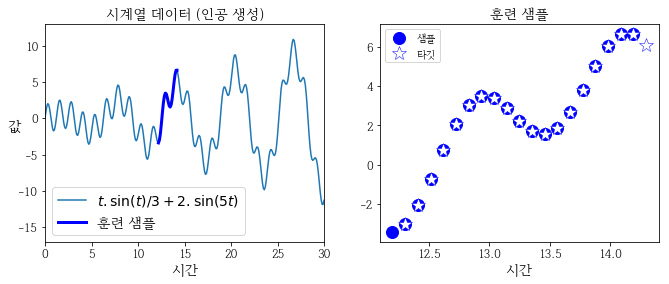

In [12]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("시계열 데이터 (인공 생성)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="훈련 샘플")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("시간")
plt.ylabel("값", rotation=0)

plt.subplot(122)
plt.title("훈련 샘플", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="타깃")
plt.legend(loc="upper left")
plt.xlabel("시간")

plt.show()

In [36]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)     #n_neurons이 100이기때문에 100개의 출력이 나옴
cell = tf.contrib.rnn.OutputProjectionWrapper(basic_cell,output_size=n_outputs)          #이를 하나로 만들어주기위해 사용
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [45]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE", mse)
            
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE 13.497989
100 	MSE 0.43943763
200 	MSE 0.19451259
300 	MSE 0.070189424
400 	MSE 0.054701693
500 	MSE 0.05051508
600 	MSE 0.05252272
700 	MSE 0.04521688
800 	MSE 0.041345257
900 	MSE 0.04813971
1000 	MSE 0.046552315
1100 	MSE 0.042966872
1200 	MSE 0.045029324
1300 	MSE 0.04121492
1400 	MSE 0.041104518


In [46]:
with tf.Session() as sess:                          # 책에는 없음
    saver.restore(sess, "./my_time_series_model")   # 책에는 없음

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


Text(0.5, 0, '시간')

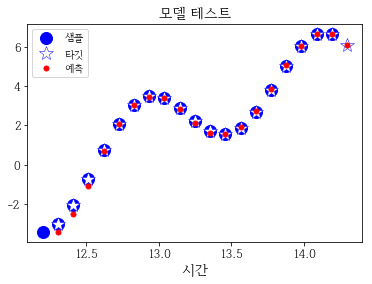

In [48]:
plt.title("모델 테스트", fontsize=14) 
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="타깃")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="예측")
plt.legend(loc="upper left")
plt.xlabel("시간")

OutputProjectionWrapper를 사용하면 RNN의 출력 시퀀스 차원을 타임 스텝마다 하나의 값으로 간단히 줄일 수 있지만 아주 효율적이지는 않습니다. 조금 복잡하지만 더 효율적인 방법이 있습니다.
![시퀀스 분류기 훈련](.\images\ch14fig8.png)

RNN의 출력을 [batch_size, n_steps, n_neurons]에서 [batch_size * n_steps, n_neurons]로 바꾸고, 출력 크기에 맞게 단일 완전 연결층을 적용해 출력 텐서의 크기를 [batch_size * n_steps, n_outputs]로 만들고 그 다음에 이 텐서의 크기를 [batch_size, n_steps, n_outputs]로 바꿉니다. 이 방법은 하나의 완전 연결층만 만들기 때문에 속도가 더 빠릅니다.
<br><br>

코드로 구현해보겠습니다.

In [5]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)    # OutputProjectionWrapper를 사용하지 않습니다.
rnn_outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])      # rnn_outputs을 [batch_size*n_steps, n_neurons]로
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)   # stacked_rnn_outputs을 [batch_size*n_steps, n_outputs]로  
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])     # stacked_outputs을 [batch_size, n_steps, n_outputs]로

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [37]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE", mse)
            
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE 15.446297
100 	MSE 0.45418876
200 	MSE 0.23695773
300 	MSE 0.1135872
400 	MSE 0.06159734
500 	MSE 0.05309548
600 	MSE 0.05470209
700 	MSE 0.04606996
800 	MSE 0.04299157
900 	MSE 0.049050324
1000 	MSE 0.04837613
1100 	MSE 0.04370436
1200 	MSE 0.045954827
1300 	MSE 0.040692154
1400 	MSE 0.042417493


INFO:tensorflow:Restoring parameters from ./my_time_series_model


Text(0.5, 0, '시간')

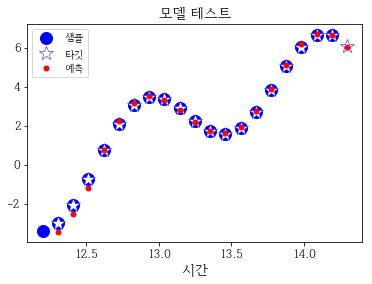

In [13]:
with tf.Session() as sess:                          # 책에는 없음
    saver.restore(sess, "./my_time_series_model")   # 책에는 없음

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
plt.title("모델 테스트", fontsize=14) 
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="타깃")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="예측")
plt.legend(loc="upper left")
plt.xlabel("시간")

## 14.3.3 RNN의 창조성
<br>

지금까지 예측 모델을 만들었습니다. 우리는 이 모델을 이용해서 새로운 시퀀스를 만들어낼 수도 있습니다. 생성에 필요한 것은 n_steps 값을 가지는 시드 시퀀스(예를 들면 0으로 체워진 시퀀스)입니다. 예측한 값을 시퀀스 끝에 추가하고, 마지막 n_steps값을 모델에 주입하여 다음 값을 예측합니다.
<br><br>

코드를 통해 보겟습니다.

In [38]:
with tf.Session() as sess:                        # 책에는 없음
    saver.restore(sess, "./my_time_series_model") # 책에는 없음, 우리가 학습시킨 모델을 불러옴

    sequence1 = [0.] * n_steps                     # 0으로 채워진 n_steps(20) 짜리 시퀀스
    for iteration in range(300):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)        # 입력을 위해 reshape
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


Text(0, 0.5, '값')

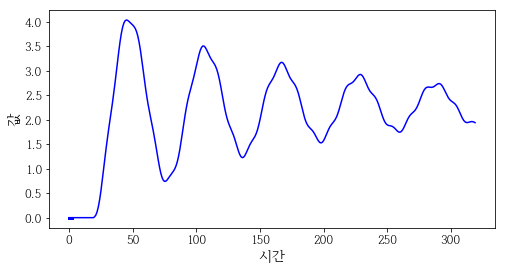

In [39]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence1)), sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("시간")
plt.ylabel("값")

In [40]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


Text(0, 0.5, '값')

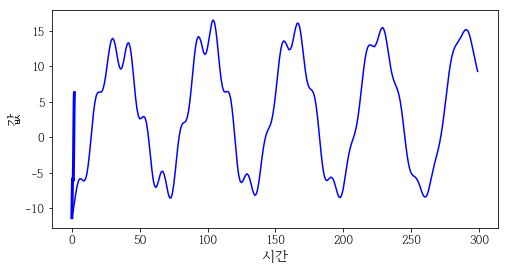

In [41]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence2)), sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("시간")
plt.ylabel("값")

## 14.4 심층 RNN
<br>

일반적으로 셀을 여러층으로 구성하며, 이를 심층 RNN(Deep RNN)이라고 합니다.
![시퀀스 분류기 훈련](.\images\ch14fig9.png)

심층 RNN을 텐서플로로 구현하려면 여러 개의 셀을 만들어 MultiRNNCell로 쌓아올립니다.

In [49]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

n_neurons = 100
n_layers = 3                                                  

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)                      # 3개의 셀을 쌓아올림
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers, state_is_tuple=True)     # True로 하면 states는 층마다 하나의 텐서를 가진 튜플
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)      # False로 하면 열 방향으로 합쳐져서 
                                                                                # states는 하나의 텐서를 가진 튜플이 됨
                                                                    # False로하면 MultiRNNCell이 한 GPU에서 모든 셀을 하나로 합침
                                                                    # 즉, 비효율적
init = tf.global_variables_initializer()

X_batch = np.random.rand(2, n_steps, n_inputs)

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

## 14.4.2 드롭아웃 적용하기
<br>

아주 깊은 RNN을 만들면 당연히 과대적합되기 쉽습니다. 이를 해결할 방법중 하나로 드롭아웃이 있습니다. RNN의 전후에 드롭아웃 층을 추가할 수 있습니다. RNN층 사이에도 적용하려면 DropoutWrapper클래스를 사용하면 됩니다.

In [51]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

keep_prob = tf.placeholder_with_default(1.0, shape=())          # 훈련할때는 어느 값이나 가능하고 테스트 할때는 1.0(드롭아웃을 끔)
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)       # 층 쌓기
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)         # 셀 사이에 드롭아웃 생성
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [52]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5           # 훈련하는 동안 keep_prob값 설정(일반저긍로 0.5)

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "훈련 MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 훈련 MSE: 16.274147
100 훈련 MSE: 4.1730213
200 훈련 MSE: 3.917807
300 훈련 MSE: 3.9105227
400 훈련 MSE: 2.6072228
500 훈련 MSE: 3.3694174
600 훈련 MSE: 3.2502887
700 훈련 MSE: 3.6406426
800 훈련 MSE: 3.7851806
900 훈련 MSE: 3.3350742
1000 훈련 MSE: 3.9514844
1100 훈련 MSE: 4.0015836
1200 훈련 MSE: 3.0850704
1300 훈련 MSE: 2.7186205
1400 훈련 MSE: 3.7485738


In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


드롭아웃이 잘 적용된 것을 확인할 수 있습니다.

## 14.4.3 많은 타임 스텝에서 훈련의 어려움
<br>

긴 시퀀스로 RNN을 훈련시키면 RNN은 매우 깊은 네트워크가 됩니다(시간이 아주 오래 걸립니다.). 그리고 11장에서도 다루었던 것처럼 그래디언트 소실이나 폭주도 가질 수 있습니다. 이를 해결하기 위한 여러가지 방법이 있습니다. 그 중 몇가지를 해결하기 위한 기법을 소개하겠습니다. 가장 간단하고 일반적인 솔루션은 훈련동안 일정 타임 스텝 만큼만 RNN을 펼치는 것입니다. 이를 '제한된 타임 스텝에 역전파한다'고 말합니다. 텐서플로에서는 간단하게 입력 시퀀스를 줄려서 이를 구현할 수 있습니다.(예를 들어 시계열에서는 n_steps만 줄이면 됩니다.) 이 방법은 모델이 장기간의 데이터 패턴은 학습할 수 없다는 문제가 있습니다. 하지만 이는 줄어든 시퀀스에 오래된 데이터와 최신 데이터가 포함되게 함으로써 어느정도는 해결할 수 있습니다. 
<br><br>

긴 시간 RNN을 실행함으로써 생기는 또 다른 문제는 첫 번쨰 입력의 기억이 점차 사라진다는 것입니다. 예를 들면 영화 리뷰를 RNN을 통해 감성 분석을 할때 '이 영화는 정말 좋다.'로 시작한다고 합시다. 하지만 RNN을 훈련하는 과정에서 이 것이 점점 사라져서 끝에는 전혀 다른 분석 결과를 낼 수도 있습니다. 이런 문제를 해결하기 위해 여러 종류의 셀이 연구되었습니다.

## 14.5 LSTM 셀(Long Short-term Memory Cell)
<br>

장단기 메모리 셀은 제프 Sepp Hochreiter와 Jurgen Schmidhuber가 1997년에 소개했고, 수년간 Alex Graves, Hasim Sak. Wojciech Zaremba등 여러 연구자들에 의해 점차 성능이 향상되었습니다. 이것은 훈련이 빠르게 수렴하고 데이터에 있는 장기간의 의존성을 감지합니다. 텐서플로에선 간단하게 BsicLSTMCell을 사용하면 됩니다. 기본적으로 두 개의 상태 벡터를 관리하며 성능상의 이유로 기본적으로 나누어져 있습니다.(state_is_tuple=False로 바꿀 수 있습니다.)
![시퀀스 분류기 훈련](.\images\ch14fig10.png)

박스 안을 보면 LSTM셀은 상태가 두개의 벡터 $h_{(t)}$(단기 상태,Short-term state)와 $c_{(t)}$(장기 상태,Long-term state)로 나뉜다는 것을 알 수있습니다.
<br><br>

핵심 아이디어는 네트워크가 장기 상태에 저장할 것, 버릴 것, 그리고 읽어 들일 것을 학습하는 것입니다. 장기 기억 $c_{(t-1)}$은 네트워크를 왼쪽에서 오른쪽으로 통과하면서, 삭제 게이트(Forget gate)를 지나 일부 기억을 잃고, 덧셈 연산으로 새로운 기억의 일부를 추가합니다.(입력 게이트(Input gate)에서 선택된 기억이 추가됩니다.) 그 후 다른 추가 변환 없이 출력됩니다. 다시말해 타임 스텝마다 일부 기억이 삭제되고 추가됩니다. 또한 덧셈 연산 이후 이 장기 상태가 복사되어 tanh함수로 전달되고 그 결과는 출력 게이트(Output gate)에 의해 걸러집니다. 이것은 단기 상태 $h_{(t)}$를 만듭니다.(이 타임 스텝의 $y_{(t)}$와 동일합니다.)
<br><br>

이제 새로운 기억이 들어오는 곳과 게이트가 어떻게 작동하는지 보겠습니다.
<br><br>
먼저 입력 벡터$x_{(t)}$와 이전의 단기 상태$h_{(t-1)}$가 네개의 다른 완전 연결 층에 들어갑니다. 이 층은 모두 다른 목적을 가집니다.

 - 주요 층은 $g_{(t)}$를 출력하는 층입니다. 이 층은 현재 입력$x_{(t)}$와 $h_{(t-1)}$을 분석하는 일반적인 역할을 담당합니다. 
 - 세 개의 다른 층은 게이트 제어기(Gate controller)입니다. 로지스틱 활성화 함수를 사용하기 때문에 출력의 범위가 0에서 1사이 입니다. 출력은 원소별 곱셈 연산으로 주입되며, 0을 출력하면 게이트를 닫고, 1을 출력하면 게이트를 여는것이라고 보면 됩니다.
     - 삭제 게이트($f_{(t)}$에 의해 제어) : 장기 상태의 어느 부분이 삭제되어야 하는지 제어
     - 입력 게이트($i_{(t)}$에 의해 제어) : $g_{(t)}$의 어느 부분이 장기 상태에 더해져야 하는지 제어
     - 출력 게이트($o_{(t)}$에 의해 제어) : 장기 상태의 어느 부분을 읽어서 이 타임 스텝에 $h_{(t)}$와 $y_{(t)}$로 출력해야 하는지 제어
<br><br>

간단히 말해, LSTM 셀은 중요한 입력을 인식하기 위해 배우고, 장기 상태에 저장하고, 필요한 기간 동안 이를 보존하기 위해 학습하고, 필요할 때 추출하기 위해 학습합니다. 그래서 LSTM셀은 시계열, 긴 텍스트, 오디오 녹음 등에서 장기 패턴을 잡아내는데 아주 효율적입니다.
<br><br>

아래는 위에서 본것들의 계산식입니다.
<br>

$$i_{(t)} = σ({W_{xi}}^T \cdot x_{(t)} + {W_{hi}}^T \cdot h_{(t-1)} + b_i) $$
$$f_{(t)} = σ({W_{xf}}^T \cdot x_{(t)} + {W_{hf}}^T \cdot h_{(t-1)} + b_f) $$
$$o_{(t)} = σ({W_{xo}}^T \cdot x_{(t)} + {W_{ho}}^T \cdot h_{(t-1)} + b_o) $$
$$g_{(t)} = tanh({W_{xg}}^T \cdot x_{(t)} + {W_{hg}}^T \cdot h_{(t-1)} + b_g) $$
$$c_{(t)} = f_{(t)} \otimes c_{(t-1)} + i_{(t)} \otimes g_{(t)}$$
$$y_{(t)} = h_{(t)} = o_{(t)} \otimes tanh(c_{(t)})$$
<br>

 - $W_{xi}$,$W_{xf}$,$W_{xo}$,$W_{xg}$ : 입력 벡터 $x_{(t)}$에 각각 연결된 네 개층의 가중치 행렬
 - $W_{hi}$,$W_{hf}$,$W_{ho}$,$W_{hg}$ : 이전의 단기 상태 $h_{(t)}$에 각각 연결된 네 개층의 가중치 행렬
 - $b_i$,$b_f$,$b_o$,$b_g$ : 네 개 층 각각에 대한 편향. 텐서플로는 $b_f$를 0이 아니라 1로 체워진 벡터로 초기화해 훈련 초기에 모든게 망각되는 것을 방지함

## 14.5.1 핍홀 연결
<br>

기본 LSTM셀의 게이트 제어기는 입력$x_{(t)}$와 이전 단기 상태 $h_{(t-1)}$만 바라볼 수 있습니다. 이 게이트 제어기에 장기 상태도 조금 노출시켜 좀 더 많은 문맥을 감지하게 만든다는 아이디어가 바로 핍홀 연결(Peephole connection)이라는 LSTM 변종입니다. 이는 2000년 Felix Gers와 Jurgen Schmidhuber가 제안했습니다. 이전 장기 기억 상태$c_{(t-1)}$이 삭제 게이트와 입력 게이트의 제어기($f_{(t)}$와 $i_{(t)}$)에 추가됩니다. 그리고 현재의 장기 기억 상태 $c_{(t)}$는 출력 게이트의 제어기$o_{(t)}$에 입력으로 추가됩니다.
<br><br>

텐서플로에서는 이를 사용하려면 BasicLSTMCell 대신 LSTMCell을 사용하고 use_peepholes=True라고 지정하면 됩니다.

## 14.6 GRU 셀(Gated Recurrent Unit Cell)
<br>

게이트 순환 유닛 셀은 2014년 조경현등의 논문에서 제안되었습니다.
![시퀀스 분류기 훈련](.\images\ch14fig11.png)

GRU는 LSTM의 간소화 버젼이라고 생각하면 됩니다. 간소화 내용은 이렇습니다

 - 두 상태 벡터가 하나의 벡터 $h_{(t)}$로 합쳐짐
 - 하나의 게이트 제어기$z_{(t)}$가 삭제, 입력 게이트를 모두 제어. 1을 출력하면 삭제게이트가 열리고 입력게이트가 닫힘. 0이면 그반대. 즉 기억이 저장될 때마다 그 저장될 위치가 먼저 삭제됨
 - 출력 게이트가 없음. 전체 상태 벡터가 매 타임 스텝마다 출력. 그러나 이전 상태의 어느부분이 출력될지 제어하는 새로운 게이트 제어기$r_{(t)}$이 존재
<br><br>

이것을 식으로 나타내면 이러합니다.
<br>
$$z_{(t)} = σ({W_{xz}}^T \cdot x_{(t)} + {W_{hz}}^T \cdot h_{(t-1)} + b_z) $$
$$r_{(t)} = σ({W_{xr}}^T \cdot x_{(t)} + {W_{hr}}^T \cdot h_{(t-1)} + b_r) $$
$$g_{(t)} = tanh({W_{xg}}^T \cdot x_{(t)} + {W_{hg}}^T \cdot(r_{(t)} \otimes h_{(t-1)}) + b_g) $$
$$h_{(t)} = z_{(t)} \otimes h_{(t-1)} + (1-z_{(t)}) \otimes g_{(t)}$$
<br><br>

텐서플로에서 GRU셀을 만들려면 GRUCell을 사용하면 됩니다.

## 14.7 자연어 처리
<br>

기계 번역, 자동 요약, 파싱(Parsing), 감성 분석 등 최고의 NLP 애플리케이션 대부분은 RNN을 어느정도 기반으로 하고 있습니다.

## 14.7.1 워드 임베딩(Word Embeding)
<br>

기계 번역 모델을 살펴보려면 먼저 단어 표현 방법을 잘 선택해야 합니다. 한가지 방법은 원-핫 벡터를 표현해 각 단어를 표현하는 것입니다. 하지만 만약 전체 어휘 목록이 50000개라면 이것은 비효율적입니다. 그리고 단어간의 유사성도 이것으로 표현하기 힘들 것입니다. 이를 잘 표현할 수 있는 방법은 어휘 목록의 각 단어를 임베딩이라고 부르는 작고 밀집된 벡터(예를 들면 150차원)로 나타내는 것입니다. 그리고 신경망이 훈련을 통해 단어마다 좋은 임베딩을 학습하도록 하는 것입니다. 훈련을 통해 비슷한 단어들끼리 점차 모이게 되면서 의미있게 조직화 될것입니다. 예를 들어 임베딩은 남성/여성, 단수/복수, 형용사/명사 등으로 표현되는 여러 개의 축을 따라 나열될 수 있습니다.

### 데이터 추출

In [55]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """디렉토리 생성, 이미 있다면 그냥 통과
    
    이 함수는 파이썬 2 버전을 지원하기 위해서입니다.
    파이썬 3.2 이상이면 다음과 같이 쓸 수 있습니다:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [56]:
words = fetch_words_data()

In [57]:
words[4:11]

['term', 'of', 'abuse', 'first', 'used', 'against', 'early']

### 사전 구축

In [58]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

### 배치 생성

In [59]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # buffer 중간에 타깃 레이블을 둡니다
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [64]:
data_index=0

### 모델 구성

In [60]:
batch_size = 128
embedding_size = 128  # 임베딩 벡터 차원
skip_window = 1       # 고려할 왼쪽과 오른쪽 단어의 개수
num_skips = 2         # 레이블을 생성하기 위한 입력의 재사용 횟수

# 가까운 이웃을 샘플링하기 위해 랜덤한 검증 세트를 만듭니다.
# 검증 샘플은 가장 흔한 단어인 낮은 ID 번호를 가진 것으로 제한합니다.
valid_size = 16     # 유사도를 평가하기 위해 랜덤하게 구성할 단어 세트 크기
valid_window = 100  # 검증 샘플을 전체 샘플의 앞 부분에서만 선택합니다
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # 부정 샘플링(negative sampling)의 수

learning_rate = 0.01

In [61]:
reset_graph()

# 입력 데이터
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

vocabulary_size = 50000
embedding_size = 150

# 입력을 위해 임베딩을 조회합니다
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [62]:
# NCE 손실을 위한 변수를 만듭니다
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# 배치에서 NCE 손실의 평균을 계산합니다.Compute the average NCE loss for the batch.
# tf.nce_loss는 자동으로 손실을 평가할 때마다 음성 레이블에서 새로운 샘플을 뽑습니다.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Adam 옵티마이저
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# 미니배치 샘플과 모든 임베딩 사이의 코사인 유사도를 계산합니다
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# 초기화를 위한 연산
init = tf.global_variables_initializer()

### 모델 훈련

In [65]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\r반복: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # 훈련 연산을 평가하여 스텝을 한 단계를 업데이트합니다(session.run()에서 반환된 값을 사용합니다)
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # 평균 손실은 2000개 배치에 대한 손실의 추정입니다.
            print("스텝 ", step, "에서의 평균 손실: ", average_loss)
            average_loss = 0

        # 이 코드는 비용이 많이 듭니다 (500 스텝마다 ~20%씩 느려집니다)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # 가장 가까운 단어의 개수
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "%s에 가장 가까운 단어:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

반복: 0	스텝  0 에서의 평균 손실:  295.0955810546875
while에 가장 가까운 단어: ejected, unsound, cheney, zimbabwean, falsely, irr, worrying, forget,
than에 가장 가까운 단어: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
zero에 가장 가까운 단어: gnaeus, qasim, impart, antigua, transmit, bagpipes, saberhagen, prestige,
often에 가장 가까운 단어: presses, convenience, arabidopsis, jewry, mapuche, guts, macrinus, implemented,
d에 가장 가까운 단어: schuster, asgard, intriguing, catus, jewellery, leptons, goodwill, prosthetic,
most에 가장 가까운 단어: mesons, restatement, cantigas, exploded, plastics, empower, inquisitors, cows,
i에 가장 가까운 단어: adolescence, doc, lenape, prose, infantile, cracker, wear, blackened,
at에 가장 가까운 단어: buttons, imposing, bebop, breakdance, bootleg, taro, usage, crichton,
he에 가장 가까운 단어: transitioned, winchell, resh, goldsmiths, standardised, markings, pursued, satirized,
use에 가장 가까운 단어: enumerated, ape, hellas, alds, havilland, told, unleavened, intestine,
two에 가장 가까운 단어: annihilate, bettors, wir, cindy, epinephri

KeyboardInterrupt: 

In [ ]:
np.save("./my_final_embeddings.npy", final_embeddings)    ## 마지막 임베딩 저장

### 임베딩 그래프

In [66]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "임베딩보다 레이블이 많습니다."
    plt.figure(figsize=(18, 18))  # 인치 크기
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

## 14.7.2 기계 번역을 위한 인코더-디코더 네트워크
<br>

영어 문장을 프랑스어로 번역해주는 간단한 기계 번역 모델을 살펴보겠습니다.
![인코더-디코더 네트워크1](.\images\ch14fig12.png)

각 스텝마다 디코더는 출력 어휘 목록에 있는 각 단어의 점수를 출력한다음 소프트맥스 층이 이 점수를 확률로 변환 시킵니다. 그리고 확률이 높은 단어를 출력합니다.

훈련이 끝난뒤 추론을 할 때는 디코더에 주입할 타긴 문장이 없습니다. 따라서 이전 스텝에서 출력한 단어를 디코더에 주입합니다.
![인코더-디코더 네트워크2](.\images\ch14fig13.png)

In [68]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # 영어 문장
Y = tf.placeholder(tf.int32, [None, n_steps]) # 프랑스어 번역
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # 1D 텐서의 리스트
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # 1D 텐서의 리스트

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [69]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()